<a href="https://colab.research.google.com/github/DaheePark0415/Econ512-Fall2024/blob/main/IO_HW2_Dahee%20Park.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1(a):
Compute $$ \bar{y}_{t}, σ_{y_{t}}, \bar{p}_{t} $$ for each market.
Compute $$ cor(\bar{y}_{t}, \bar{p}_{t}) $$
. Do consumers in wealthier markets buy more expensive products on average?

In [1]:
# importing necessary packages

import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import warnings
warnings.filterwarnings("ignore")


In [2]:
demo_data = pd.read_csv('consumer_census.csv')
income_mean_var_price = demo_data.groupby('t')['income'].agg(['mean', 'var'])

market_data = pd.read_csv('product_data_ps2.csv')
market_data['weighted_price'] = market_data['market_share']*market_data['price']

income_mean_var_price['mean_price'] = market_data.groupby('t')['weighted_price'].sum()
market_data = market_data.drop(columns=['weighted_price'])

income_mean_var_price = income_mean_var_price.rename(columns={'mean':'mean_income', 'var':'var_income'})
print(income_mean_var_price.head(5))

corr = income_mean_var_price['mean_income'].corr(income_mean_var_price['mean_price'])

print(f'The correlation between mean income and average price among markets is {corr}')

   mean_income  var_income  mean_price
t                                     
1     6.002591    0.266339    2.059838
2     4.550203    0.236291    2.173610
3     5.929497    0.233196    2.335994
4     4.432515    0.241526    2.047550
5     4.451567    0.263197    2.365136
The correlation between mean income and average price among markets is 0.15430274953743148


# 1(b) Draw Consumer Data
A function 'draw_consumer' generates a simulated sample of consumers based on the observed distribution of income and unobserved heterogeneity for sugar and caffeine preferences.

*   Market_number : The observed distribution of income values from the census data
*   Size : the sample size, i.e. the number of consumers to be simulated
*   seed : the random seed for reproducibility







In [3]:
def gen_consumer(Market_number:int, Size:int, Seed:int)->float:
    # This function draws customers from a market
    # argument for seed is included for replicability

    sample = demo_data[demo_data.t == Market_number].sample(n=Size, replace=True, random_state=Seed) # Sampling with replacement

    np.random.seed(Seed)

    sample['nu_1'], sample['nu_2'] = np.random.standard_normal(Size), np.random.standard_normal(Size)

    return sample

temp = {'mean_income':[], 'var_income':[], 'mean_nu_1':[], 'var_nu_1':[], 'mean_nu_2':[], 'var_nu_2':[]}

for i in range(1, 51):
    simulated_data = gen_consumer(i, 100, i) # As there is no instruction, I will use market number as the seed each market
    temp['mean_income'].append(simulated_data['income'].mean())
    temp['var_income'].append(simulated_data['income'].var())
    temp['mean_nu_1'].append(simulated_data['nu_1'].mean())
    temp['var_nu_1'].append(simulated_data['nu_1'].var())
    temp['mean_nu_2'].append(simulated_data['nu_2'].mean())
    temp['var_nu_2'].append(simulated_data['nu_2'].var())

df = pd.DataFrame(temp)
df.index += 1
df.index.name = 't'

df.head(5)

,mean_income,var_income,mean_nu_1,var_nu_1,mean_nu_2,var_nu_2
t,,,,,,
1,5.917419,0.252275,0.060583,0.791416,0.152795,0.877388
2,4.570960,0.239593,-0.103741,1.086306,0.128241,1.243061
3,5.949333,0.239335,-0.108637,1.143517,-0.032944,0.780795
4,4.430244,0.251779,0.035274,0.956122,0.021808,0.881465
5,4.450541,0.238198,0.091547,0.875472,0.027212,1.076421


 Generating larger, comprehensive samples (500 consumers) for each market and combining them into one unified DataFrame (CONSUMER).

 This code creates a unified DataFrame called simulated_consumer that contains consumer data simulated for all markets (from 1 to 50), with 500 consumers per market. The resulting DataFrame organizes the consumer characteristics (income, nu_1, nu_2) along with the market identifier (t).

In [4]:
simulated_consumer = pd.DataFrame()

for i in range(1, 51):
    temp = gen_consumer(i, 500, i)
    temp = temp.drop(columns=['consumer_ID'])
    simulated_consumer = pd.concat([simulated_consumer, temp])

simulated_consumer = simulated_consumer.reset_index(drop=True)[['income', 'nu_1', 'nu_2', 't']]
print(simulated_consumer.head(5))

     income      nu_1      nu_2  t
0  5.989803  1.624345 -1.719394  1
1  5.200218 -0.611756  0.057121  1
2  6.145651 -0.528172 -0.799547  1
3  5.320450 -1.072969 -0.291595  1
4  6.454278  0.865408 -0.258983  1


# 1(c) Estimate share equation
The task is to calculate the probability that consumer $i$ in market $t$, with characteristics given by $ y_{it}, \nu_{1it},$ and $\nu_{2it}$, chooses product $j$. The probability is given by:

$s_{ijt}(\delta_t, \theta_2) = \frac{\exp(\delta_{jt} + \mu_{ijt}(\theta_2))}{1 + \sum_{k \in J_t} \exp(\delta_{kt} + \mu_{ikt}(\theta_2))}
$

where:
- $ \delta_{jt} $ represents the mean utility for product j in market t.
- $ \mu_{ijt}(\theta_2)$ is the consumer-specific utility component influenced by the parameters $ \theta_2 = \{\alpha, \sigma_1, \sigma_2\}$

The function should use the consumer and market data to compute these probabilities for all products and consumers in market $t$. The log-sum-exp trick should be applied to ensure numerical stability, especially when handling large or very small exponential values.

$ \delta_{t}= \{\delta_{1t}, \ldots, \delta_{J_{t},t}\} $: This represents the vector of mean utilities for products $1$ to $j_{t}$ in market $t$.

$ \theta_{2} = \{\alpha, \sigma_1, \sigma_2\} $: This vector contains the parameters where:

The probabilities should be calculated using the log-sum-exp function to ensure numerical stability, especially when handling large or very small exponential valuesection to the Provided Code The code you shared computes these choice probabilities using the logit model approach, incorporating the log-sum-exp trick for stability.


In [5]:
%%time

def calculate_indiv_choice_prob(delta: np.array, theta: np.array, cons_data: pd.DataFrame, prod_data: pd.DataFrame) -> pd.DataFrame:
    # returns individual consumers' prob. vector of choosing the products
    # inputs: (estimated) delta, (estimated) theta, (simulated) consumer info, and product(Market) info
    # Use equation given to calcaulte prob. of choosing a product

    alpha, sigma1, sigma2 = theta

    prod_data['alpha_price'], prod_data['sigma1_sugar'], prod_data['sigma2_caffeine'] = prod_data['price'].multiply(alpha), prod_data['sugar'].multiply(sigma1), prod_data['caffeine'].multiply(sigma2)

    utility_labels = ['utility_'+str(j) for j in range(1, 51)]
    share_labels = ['Prob_'+str(j) for j in range(1, 51)]

    cons_data[utility_labels] = np.matmul(cons_data[['income', 'nu_1', 'nu_2']].values, prod_data[['alpha_price', 'sigma1_sugar', 'sigma2_caffeine']].values.T) + np.tile(delta, len(cons_data)).reshape(len(cons_data), len(delta))
        # The above line calculates \delta + \mu with the assumed parameter values

    cons_data['IncVal'] = np.log(cons_data[utility_labels].apply(np.exp).sum(axis = 1)+1)

    cons_data[share_labels] = np.exp(cons_data[utility_labels].values-np.tile(cons_data['IncVal'].values, (50, 1)).T)

    cons_data = cons_data[share_labels]

    return cons_data

calculate_indiv_choice_prob(delta=50*[1], theta=[.1, .1, .1], cons_data=simulated_consumer[simulated_consumer.t == 1], prod_data=market_data[market_data.t == 1])

CPU times: user 45.5 ms, sys: 859 µs, total: 46.3 ms
Wall time: 49.9 ms


,Prob_1,Prob_2,Prob_3,Prob_4,Prob_5,Prob_6,Prob_7,Prob_8,Prob_9,Prob_10,...,Prob_41,Prob_42,Prob_43,Prob_44,Prob_45,Prob_46,Prob_47,Prob_48,Prob_49,Prob_50
0,0.011320,0.016083,0.011806,0.014005,0.011482,0.008297,0.012041,0.013920,0.014621,0.016126,...,0.023780,0.016176,0.020872,0.047673,0.035726,0.052284,0.025130,0.026186,0.025864,0.019614
1,0.021976,0.019592,0.017874,0.016092,0.016833,0.021871,0.021555,0.025404,0.017821,0.018589,...,0.017527,0.020119,0.016583,0.022393,0.025021,0.021257,0.021935,0.021409,0.017491,0.016397
2,0.020071,0.019344,0.017782,0.016605,0.017289,0.018142,0.019947,0.022351,0.018184,0.019095,...,0.018817,0.019707,0.017812,0.024801,0.026044,0.024907,0.022063,0.021729,0.019213,0.017745
3,0.023202,0.019891,0.019596,0.017150,0.018990,0.022885,0.022593,0.025033,0.018877,0.019428,...,0.017032,0.020325,0.016557,0.019300,0.022372,0.018705,0.020444,0.019827,0.016977,0.016741
4,0.015551,0.017538,0.012884,0.013320,0.011706,0.013660,0.015902,0.020850,0.014791,0.016237,...,0.020312,0.018059,0.017734,0.039050,0.035611,0.038046,0.026087,0.026304,0.021083,0.016606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.022450,0.019598,0.018051,0.015925,0.017042,0.022069,0.021938,0.025895,0.017853,0.018677,...,0.017161,0.020159,0.016234,0.022017,0.025129,0.020976,0.021799,0.021179,0.017152,0.016141
496,0.013997,0.017787,0.015824,0.017468,0.016408,0.010381,0.014587,0.014553,0.017875,0.018967,...,0.023198,0.017682,0.021849,0.033625,0.027869,0.038219,0.022204,0.022758,0.024969,0.021646
497,0.028305,0.020158,0.023149,0.018094,0.022925,0.030569,0.026674,0.027700,0.020073,0.019970,...,0.014099,0.020606,0.014477,0.012064,0.016436,0.011423,0.016946,0.016003,0.013652,0.015233
498,0.024514,0.019839,0.018912,0.016041,0.017704,0.025795,0.023643,0.028017,0.018042,0.018638,...,0.015998,0.020469,0.015351,0.018793,0.022836,0.017359,0.020808,0.020025,0.015708,0.015351


# 1(d). Compute the conditional shares $S_{ijt}$
The task in 1(d) is to compute the choice probabilities for consumers across all markets and return a unified DataFrame containing these probabilities. The goal is to implement a function, generate_total_df, which maps given parameters and product attributes to the resulting choice probabilities for each product in each market. This function essentially extends the method developed in 1(c) to cover all markets (from 1 to 50) comprehensively.

*  Iterating through all markets (1 to 50).
*  Computing these probabilities based on product attributes and model parameters.
*  Combining the results into a single, unified DataFrame that contains choice probabilities for each consumer in each market.


In [6]:
%%time
def calculate_delta(params: np.array, prod_data: pd.DataFrame) -> np.array:
    bar_alpha, bar_beta1, bar_beta2, gamma = params

    prod_data['delta'] = bar_alpha*prod_data['price']+bar_beta1*prod_data['sugar']+bar_beta2*prod_data['caffeine'] + gamma

    return prod_data['delta'].values


params = np.array([-1, 0.5, 0.5, -1.5])
theta1 = np.array([0, 0, 0])
theta2 = np.array([0, 1, 1])

estimation1 = pd.DataFrame()
estimation2 = pd.DataFrame()

for i in range(1, 51):
    delta = calculate_delta(params, market_data[market_data.t == i])

    estimation1 = pd.concat([estimation1, calculate_indiv_choice_prob(delta, theta1, simulated_consumer[simulated_consumer.t == i], market_data[market_data.t == i])])
    estimation2 = pd.concat([estimation2, calculate_indiv_choice_prob(delta, theta2, simulated_consumer[simulated_consumer.t == i], market_data[market_data.t == i])])

estimation1

CPU times: user 5.43 s, sys: 60.7 ms, total: 5.49 s
Wall time: 5.59 s


,Prob_1,Prob_2,Prob_3,Prob_4,Prob_5,Prob_6,Prob_7,Prob_8,Prob_9,Prob_10,...,Prob_41,Prob_42,Prob_43,Prob_44,Prob_45,Prob_46,Prob_47,Prob_48,Prob_49,Prob_50
0,0.011167,0.016010,0.008614,0.011992,0.006659,0.014940,0.011940,0.019120,0.011355,0.012018,...,0.023610,0.016467,0.019658,0.049733,0.034503,0.038958,0.029779,0.032066,0.022819,0.015901
1,0.011167,0.016010,0.008614,0.011992,0.006659,0.014940,0.011940,0.019120,0.011355,0.012018,...,0.023610,0.016467,0.019658,0.049733,0.034503,0.038958,0.029779,0.032066,0.022819,0.015901
2,0.011167,0.016010,0.008614,0.011992,0.006659,0.014940,0.011940,0.019120,0.011355,0.012018,...,0.023610,0.016467,0.019658,0.049733,0.034503,0.038958,0.029779,0.032066,0.022819,0.015901
3,0.011167,0.016010,0.008614,0.011992,0.006659,0.014940,0.011940,0.019120,0.011355,0.012018,...,0.023610,0.016467,0.019658,0.049733,0.034503,0.038958,0.029779,0.032066,0.022819,0.015901
4,0.011167,0.016010,0.008614,0.011992,0.006659,0.014940,0.011940,0.019120,0.011355,0.012018,...,0.023610,0.016467,0.019658,0.049733,0.034503,0.038958,0.029779,0.032066,0.022819,0.015901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,0.007747,0.008908,0.011236,0.015061,0.008732,0.006141,0.008557,0.009395,0.014914,0.011239,...,0.044125,0.032571,0.028406,0.020437,0.046219,0.016794,0.016745,0.040449,0.012979,0.015360
24996,0.007747,0.008908,0.011236,0.015061,0.008732,0.006141,0.008557,0.009395,0.014914,0.011239,...,0.044125,0.032571,0.028406,0.020437,0.046219,0.016794,0.016745,0.040449,0.012979,0.015360
24997,0.007747,0.008908,0.011236,0.015061,0.008732,0.006141,0.008557,0.009395,0.014914,0.011239,...,0.044125,0.032571,0.028406,0.020437,0.046219,0.016794,0.016745,0.040449,0.012979,0.015360
24998,0.007747,0.008908,0.011236,0.015061,0.008732,0.006141,0.008557,0.009395,0.014914,0.011239,...,0.044125,0.032571,0.028406,0.020437,0.046219,0.016794,0.016745,0.040449,0.012979,0.015360


In [ ]:
estimation2

,Prob_1,Prob_2,Prob_3,Prob_4,Prob_5,Prob_6,Prob_7,Prob_8,Prob_9,Prob_10,...,Prob_41,Prob_42,Prob_43,Prob_44,Prob_45,Prob_46,Prob_47,Prob_48,Prob_49,Prob_50
0,9.481767e-07,0.000058,0.000010,1.304996e-04,0.000013,9.518978e-08,0.000002,0.000001,6.289774e-05,0.000091,...,4.799781e-03,4.698196e-05,2.790341e-03,1.314967e-01,3.656440e-03,4.231553e-01,0.000815,1.494974e-03,0.009421,1.753159e-03
1,3.219858e-02,0.018125,0.021085,1.632048e-02,0.018327,6.429871e-02,0.029183,0.033798,1.641691e-02,0.014824,...,9.669341e-03,1.871244e-02,1.051951e-02,5.222534e-03,8.238249e-03,3.717767e-03,0.012481,1.171316e-02,0.008167,1.047164e-02
2,3.427066e-03,0.004374,0.007460,9.053870e-03,0.010160,2.835338e-03,0.003561,0.001740,6.835791e-03,0.005941,...,5.487379e-03,3.976754e-03,6.960281e-03,2.023498e-03,1.628341e-03,2.733385e-03,0.002464,2.580688e-03,0.005708,7.916284e-03
3,1.993477e-02,0.007628,0.019881,1.172298e-02,0.023395,3.676733e-02,0.016814,0.010035,1.085307e-02,0.008457,...,2.631320e-03,7.449502e-03,3.823312e-03,3.919912e-04,8.866834e-04,3.468392e-04,0.002126,1.875965e-03,0.002192,4.795282e-03
4,3.775084e-04,0.002348,0.000470,1.623042e-03,0.000340,2.409619e-04,0.000522,0.001093,1.330592e-03,0.001741,...,1.695993e-02,2.339526e-03,1.006614e-02,2.174532e-01,4.195573e-02,2.224850e-01,0.016600,2.212891e-02,0.020641,6.279948e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,1.517968e-05,0.000002,0.000004,9.138470e-07,0.000018,8.827298e-05,0.000006,0.000038,1.863703e-07,0.000001,...,2.756517e-09,2.643435e-08,1.043556e-07,3.910582e-07,3.338714e-09,1.207973e-07,0.000002,7.286007e-08,0.000005,7.606610e-07
24996,8.176602e-03,0.025262,0.014461,1.098348e-02,0.050706,1.012722e-02,0.043539,0.007240,6.239207e-02,0.044021,...,2.711065e-03,2.645724e-03,1.642079e-03,8.155743e-03,6.358945e-03,9.866453e-03,0.003968,2.670280e-04,0.003542,5.548271e-03
24997,1.364514e-04,0.000050,0.000055,1.531100e-05,0.000381,6.265511e-04,0.000156,0.000247,1.113264e-05,0.000044,...,6.447523e-08,3.918095e-07,9.113588e-07,6.289079e-06,1.144191e-07,2.982211e-06,0.000018,2.454040e-07,0.000033,9.300956e-06
24998,3.441870e-04,0.000665,0.000889,2.393128e-03,0.000262,1.247085e-04,0.000380,0.000348,2.764109e-03,0.000995,...,1.286722e-01,3.703463e-02,2.075068e-02,5.516682e-03,1.071923e-01,5.819204e-03,0.002571,6.111626e-02,0.001348,3.059243e-03


# 1(e). estimate market share





In [7]:
def estimated_share(delta:np.array, theta:np.array, cons_data: pd.DataFrame, prod_data: pd.DataFrame) -> np.array:

    return calculate_indiv_choice_prob(delta, theta, cons_data, prod_data).mean(axis = 0).values

params = np.array([-1, 0.5, 0.5, -1.5])
theta2 = np.array([0, 1, 1])

estimation = pd.DataFrame()

for j in range(1, 51):
    delta = calculate_delta(params, market_data[market_data.t == j])
    temp = market_data[market_data.t == j].copy()
    temp['estimated_market_share'] = estimated_share(delta, theta2, simulated_consumer[simulated_consumer.t == j], market_data[market_data.t == j])
    estimation = pd.concat([estimation, temp])
estimation

,product_ID,price,sugar,caffeine,corn_syrup_price,caffeine_extract_price,quantity,t,market_share,estimated_market_share
0,1,2.021334,1.580856,6.074459,0.199022,0.264899,223,1,0.0223,0.011505
1,2,1.980251,3.033151,5.260598,0.199022,0.264899,39,1,0.0039,0.006248
2,3,1.655560,1.718876,4.685728,0.199022,0.264899,83,1,0.0083,0.005534
3,4,1.566470,2.637858,4.250370,0.199022,0.264899,16,1,0.0016,0.005016
4,5,1.517629,1.476214,4.137802,0.199022,0.264899,141,1,0.0141,0.005074
...,...,...,...,...,...,...,...,...,...,...
2495,46,2.368628,3.699026,5.598460,0.210564,0.255062,252,50,0.0252,0.005890
2496,47,1.719465,4.031755,3.961574,0.210564,0.255062,12,50,0.0012,0.005546
2497,48,2.529186,7.770437,3.606250,0.210564,0.255062,1158,50,0.1158,0.103717
2498,49,1.674552,3.751779,3.642175,0.210564,0.255062,30,50,0.0030,0.004842


In [8]:
estimated_income_price = pd.DataFrame()
estimated_income_price['estimated_income_mean'] = simulated_consumer.groupby('t')['income'].mean()

estimation['estimated_weighted_price'] = estimation['estimated_market_share']*estimation['price']
estimated_income_price['estimated_weighted_price'] = estimation.groupby('t')['estimated_weighted_price'].mean()

print(estimated_income_price.head(5))

corr = estimated_income_price['estimated_income_mean'].corr(estimated_income_price['estimated_weighted_price'])

print(f'The correlation between estimated mean income and average price among markets is {corr}')

   estimated_income_mean  estimated_weighted_price
t                                                 
1               6.019233                  0.037948
2               4.586257                  0.035876
3               5.960620                  0.039291
4               4.426046                  0.039019
5               4.423433                  0.041452
The correlation between estimated mean income and average price among markets is 0.06855609186804149


# 2(a). Solve  δ  by contraction mapping with sample size 100

This line updates the δ values using the contraction mapping equation: \
  $ \delta^{new}_{jt} = \delta_{jt} + log(s^{obs}_{jt}) - log(s^{est}_{jt})$ \
This equation adjusts the values to minimize the difference between observed and estimated shares.

In [9]:
def solve_delta(theta:np.array, delta:np.array, cons_data:pd.DataFrame, prod_data:pd.DataFrame, tol=1e-4)->np.array:
    error = 1

    while error>tol:
        new_delta = delta+np.log(prod_data['market_share'].values)-np.log(estimated_share(delta, theta, cons_data, prod_data))
        error = np.linalg.norm(new_delta-delta)
        delta = new_delta

    return delta


The code provided simulates and estimates the distribution of the  δ1  value (mean utility for the first product) across 100 different simulations, using the solve_delta function and parallel processing for efficiency.

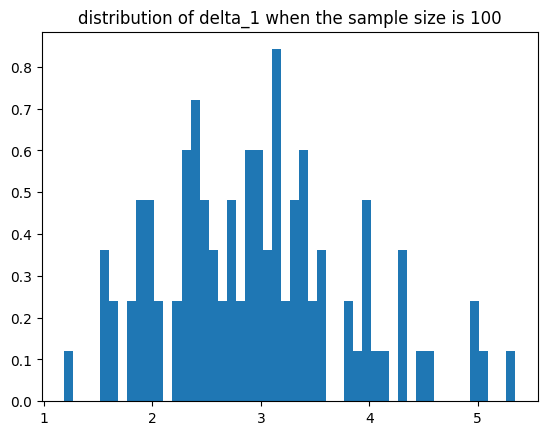

sample mean of delta_1 is 2.94702849054161 and sample variance is 0.7348973737689057
CPU times: user 4.47 s, sys: 848 ms, total: 5.32 s
Wall time: 5min 46s


In [10]:
%%time

# Initializing delta
# Given that update_delta is a contraction mapping, any initial guess would not effect the convergence result after sufficient number of update.

theta = np.array([0, 1, 1])

deltas = Parallel(n_jobs=-1, backend='loky')(delayed(solve_delta)(theta, np.array(50*[1]), gen_consumer(1, 100, t), market_data[market_data.t == 1]) for t in range(100))

delta_0s = [deltas[i][0] for i in range(100)]
plt.hist(delta_0s, bins = 50, density = True)
plt.title('distribution of delta_1 when the sample size is 100')
plt.show()
print(f'sample mean of delta_1 is {np.mean(np.array(delta_0s))} and sample variance is {np.var(np.array(delta_0s))}')

# 2(b) sample size 500

It uses a sample size of 500 consumers per simulation (instead of 100), to estimate the distribution of the $ 𝛿_{1} $ value across 100 different simulations.

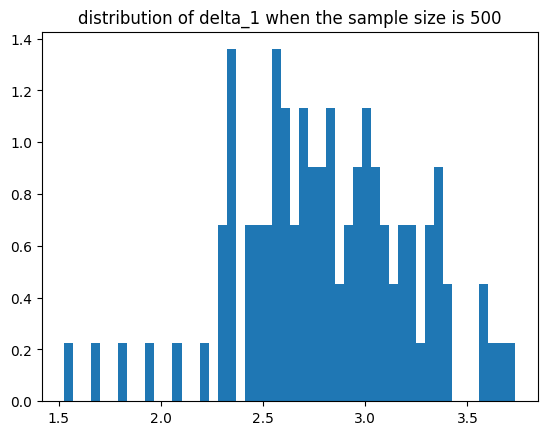

sample mean of delta_1 is 2.8061515913204587 and sample variance is 0.17705003977501085
CPU times: user 4.51 s, sys: 824 ms, total: 5.34 s
Wall time: 6min 4s


In [11]:
%%time

# Initializing delta
# Given that update_delta is a contraction mapping, any initial guess would not effect the convergence result after sufficient number of update.

theta = np.array([0, 1, 1])

deltas = Parallel(n_jobs=-1, backend='loky')(delayed(solve_delta)(theta, np.array(50*[1]), gen_consumer(1, 500, t), market_data[market_data.t == 1]) for t in range(100))

delta_0s = [deltas[i][0] for i in range(100)]
plt.hist(delta_0s, bins = 50, density = True)
plt.title('distribution of delta_1 when the sample size is 500')
plt.show()
print(f'sample mean of delta_1 is {np.mean(np.array(delta_0s))} and sample variance is {np.var(np.array(delta_0s))}')


# 3(a)
The code provided for Problem 3(a) involves creating instruments for a regression model using instrumental variables (IV) and calculating the necessary matrices for IV estimation. The code applies Ordinary Least Squares (OLS) to estimate predicted prices ( p̂  ) and constructs instrument matrices for further analysis.

In [12]:
def IV_caffeine(row):
    t, caf = row['t'], row['caffeine']
    temp = Market_data[Market_data.t == t]
    temp['square'] = Market_data['caffeine'].apply(lambda x: (x-caf)**2)

    return temp[['square']].sum()

def IV_sugar(row):
    t, sug = row['t'], row['sugar']
    temp = Market_data[Market_data.t == t]
    temp['square'] = Market_data['sugar'].apply(lambda x: (x-sug)**2)

    return temp[['square']].sum()

Market_data = market_data.copy()

Market_data['IV_sugar'], Market_data['IV_caffeine'] = Market_data['corn_syrup_price']*Market_data['sugar'], Market_data['caffeine_extract_price']*Market_data['caffeine']
X = sm.add_constant(Market_data[['IV_sugar', 'IV_caffeine']].values)
model = sm.OLS(Market_data['price'].values, X)
results = model.fit()
Market_data['p_hat'] = results.predict(X)
Market_data = pd.merge(Market_data, demo_data.groupby('t').mean()[['income']], on = 't', how = 'left')
Market_data['p_hat_mean_income'] = Market_data['p_hat']*Market_data['income']
Market_data['caffeine_squaresum'] = Market_data.apply(IV_caffeine, axis = 1)
Market_data['sugar_squaresum'] = Market_data.apply(IV_sugar, axis = 1)

X = sm.add_constant(Market_data[['price', 'sugar', 'caffeine']].values)
Z = sm.add_constant(Market_data[['sugar', 'caffeine', 'p_hat', 'p_hat_mean_income', 'caffeine_squaresum', 'sugar_squaresum']].values) # Instrument matrix
W = np.linalg.inv(Z.T@Z/2500)

3 (b)


In [17]:
# Generate 10000 consumers form each market

simulated_consumer = pd.DataFrame()

for i in range(1, 51):
    temp = gen_consumer(i, 10000, i)
    temp = temp.drop(columns=['consumer_ID'])
    simulated_consumer = pd.concat([simulated_consumer, temp])

In [18]:
%%time

def GMM(theta:np.array)->float:
    global GMM_deltas, alpha, beta1, beta2, gamma

    try:
        GMM_deltas = Parallel(n_jobs=-1, backend='loky')(delayed(solve_delta)(theta, GMM_deltas[t-1], simulated_consumer[simulated_consumer.t == t], market_data[market_data.t == t]) for t in range(1, 51))
    except:
        GMM_deltas = Parallel(n_jobs=-1, backend='loky')(delayed(solve_delta)(theta, np.array(50*[1]), simulated_consumer[simulated_consumer.t == t], market_data[market_data.t == t]) for t in range(1, 51))


    long_GMM_deltas = np.concatenate(GMM_deltas)
    alpha, beta1, beta2, gamma = np.linalg.inv(X.T@Z@W@Z.T@X)@(X.T@Z@W@Z.T@long_GMM_deltas)
    temp_market = Market_data[['price', 'sugar', 'caffeine']].copy()
    temp_market['xi_hat'] = long_GMM_deltas - temp_market['price'].multiply(alpha) - temp_market['sugar'].multiply(beta1) - temp_market['caffeine'].multiply(beta2)-gamma

    return (Z.T@temp_market['xi_hat'].values/2500).T@W@(Z.T@temp_market['xi_hat'].values/2500)

print(f'The value of q(theta) evaluated at (-.5, 2, 2) is {GMM(np.array([-.5, 2, 2]))}')



The value of q(theta) evaluated at (-.5, 2, 2) is 25.708808023898815
CPU times: user 12.9 s, sys: 2.63 s, total: 15.5 s
Wall time: 22min 54s


# 3(c). compute the analytical gradient of the GMM objective function

To calculate the analystic derivative, we have to calculate certain drivatives. For expositional purposes, I drop $t$, the time index.

$$
\frac{\partial \hat{s}_i}{\partial \delta_i} = \hat{s}_i(1-\hat{s}_i)
$$

$$
\frac{\partial \hat{s}_i}{\partial \delta_j} = -\hat{s}_i \hat{s}_j
$$

and for $\kappa \in \{\alpha, \sigma_1, \sigma_2\}$,

$$
\frac{\partial \hat{s}_j}{\partial \kappa} = \frac{1}{cons\_ pop}\sum_i\left( \frac{\partial\mu_{ij}}{\partial \kappa} P_{ij} -P_{ij}\sum_{j'} P_{ij'} \frac{\partial \mu_{ij'}}{\partial \kappa} \right)
$$

where $P_{ij}$ is the probability of consumer $i$ choosing $j$.

and The partial derivatives of $ μ_{ij} $ with respect to the parameters ($ α, σ_{1}, \sigma_{2}$) are:

$$
\frac{\partial\mu_{ij}}{\partial \alpha} = p_jy_{i},~\frac{\partial\mu_{ij}}{\partial \sigma_1} = sug_j\nu_{i1},~\frac{\partial\mu_{ij}}{\partial \sigma_2}=caf_j\nu_{i2}
$$

In [19]:
def Analytic_derivative(theta:np.array)->np.array:

    GMM(theta) # to retrive delta

    long_GMM_deltas = np.concatenate(GMM_deltas)
    alpha, beta1, beta2, gamma = np.linalg.inv(X.T@Z@W@Z.T@X)@(X.T@Z@W@Z.T@long_GMM_deltas)
    temp_market = Market_data[['price', 'sugar', 'caffeine']].copy()
    temp_market['xi_hat'] = long_GMM_deltas - temp_market['price'].multiply(alpha) - temp_market['sugar'].multiply(beta1) - temp_market['caffeine'].multiply(beta2)-gamma


    temp = pd.DataFrame()

    share_labels = ['Prob_'+str(j) for j in range(1, 51)]
    temp_income_price_labels = ['Temp_Income_Price_'+str(j) for j in range(1, 51)]
    temp_sug_nu1_labels = ['Temp_Sug_Nu1_'+str(j) for j in range(1, 51)]
    temp_caf_nu2_labels = ['Temp_Caf_Nu2_'+str(j) for j in range(1, 51)]

    income_price_labels = ['Income_Price_'+str(j) for j in range(1, 51)]
    sug_nu1_labels = ['Sug_Nu1_'+str(j) for j in range(1, 51)]
    caf_nu2_labels = ['Caf_Nu2_'+str(j) for j in range(1, 51)]

    for t in range(1, 51):

        length = len(simulated_consumer[simulated_consumer.t == t])

        period_share = estimated_share(GMM_deltas[t-1], theta, simulated_consumer[simulated_consumer.t == t], market_data[market_data.t == t])
        S_matrix = -period_share.reshape(50, 1)@period_share.reshape(50, 1).T + np.diag(period_share)

        temp = pd.concat([simulated_consumer[simulated_consumer.t == t], calculate_indiv_choice_prob(GMM_deltas[t-1], theta, simulated_consumer[simulated_consumer.t == t], market_data[market_data.t == t])], axis = 1)

        temp_income_price = temp[['income']].values*market_data[market_data.t == 1][['price']].values.T
        temp[temp_income_price_labels] = np.multiply(temp[share_labels].values, temp_income_price)

        temp_sug_nu1 = temp[['nu_1']].values*market_data[market_data.t == 1][['sugar']].values.T
        temp[temp_sug_nu1_labels] = np.multiply(temp[share_labels].values, temp_sug_nu1)

        temp_caf_nu2 = temp[['nu_2']].values*market_data[market_data.t == 1][['caffeine']].values.T
        temp[temp_caf_nu2_labels] = np.multiply(temp[share_labels].values, temp_caf_nu2)

        sum_income_price, sum_sug_nu1, sum_caf_nu2 = \
            temp[temp_income_price_labels].sum(axis = 1).values.reshape(length, 1), temp[temp_sug_nu1_labels].sum(axis = 1).values.reshape(length, 1), temp[temp_caf_nu2_labels].sum(axis = 1).values.reshape(length, 1)

        temp[income_price_labels] = np.multiply(temp[share_labels].values, temp_income_price - sum_income_price)
        temp[sug_nu1_labels] = np.multiply(temp[share_labels].values, temp_sug_nu1 - sum_sug_nu1)
        temp[caf_nu2_labels] = np.multiply(temp[share_labels].values, temp_caf_nu2 - sum_caf_nu2)

        mean_income_price, mean_sug_nu1, mean_caf_nu2 = \
            temp[income_price_labels].mean().values, temp[sug_nu1_labels].mean().values, temp[caf_nu2_labels].mean().values

        if t == 1:
            result = np.linalg.inv(S_matrix)@np.stack((temp[income_price_labels].mean().values, temp[sug_nu1_labels].mean().values, temp[caf_nu2_labels].mean().values), axis = 1)
        else:
            result = np.vstack((result, np.linalg.inv(S_matrix)@np.stack((temp[income_price_labels].mean().values, temp[sug_nu1_labels].mean().values, temp[caf_nu2_labels].mean().values), axis = 1)))

    return 2/2500*(Z.T@result).T@W@(Z.T@temp_market['xi_hat'].values/2500).T


print(f'The Analytic derivative calculated at (-.5, 2, 2) is {Analytic_derivative(np.array([-.5, 2, 2]))}')


The Analytic derivative calculated at (-.5, 2, 2) is [-17.4367586    2.69448984   7.88585087]


# 3(f)
The function Numerical_derivative calculates the numerical derivative (approximate gradient) of the GMM objective function with respect to each parameter in theta using finite differences. It evaluates how sensitive the objective function is to small changes in each parameter.

h: A small float representing the step size for finite differences

$ ∂ q(θ)/∂θ_{1} ​ ≈ GMM(θ_{1} + h, θ_{2}, θ_{3}) - GMM(θ_{1}, θ_{2}, θ_{3}) / h$

In [ ]:
def Numerical_derivative(theta:np.array, h:float)->np.array:
    temp_value = GMM(theta)
    return (GMM(theta + np.array([h, 0, 0]))-temp_value)/h, (GMM(theta + np.array([0, h, 0]))-temp_value)/h, (GMM(theta + np.array([0, 0, h]))-temp_value)/h

h = .1

a, b, c = Numerical_derivative(np.array([-.5, 2, 2]), h)

print(f'partial derivative with respect to the first argument is {a} when the step size is {h}')
print(f'partial derivative with respect to the second argument is {b} when the step size is {h}')
print(f'partial derivative with respect to the thrid argument is {c} when the step size is {h}')

partial derivative with respect to the first argument is -88.58625214730218 when the step size is 0.1
partial derivative with respect to the second argument is 9.11373537770963 when the step size is 0.1
partial derivative with respect to the thrid argument is 27.004038443488838 when the step size is 0.1


# 3(g)
The code uses the scipy.optimize.minimize function to perform the GMM (Generalized Method of Moments) estimation of the parameter vector theta using the BFGS optimization algorithm.

Specifies the optimization algorithm to use: Broyden–Fletcher–Goldfarb–Shanno (BFGS). BFGS is a quasi-Newton method that is efficient for optimization problems where the gradient of the objective function is available (as in this case).

jac stands for the Jacobian (gradient) of the objective function. In this case, it is set to Analytic_derivative, which is the function that computes the analytic gradient of the GMM objective function.



In [ ]:
result = minimize(GMM, np.array([-.5, 2, 2]), method = 'BFGS', jac = Analytic_derivative, options={'xatol': 1e-8, 'disp': True, 'maxiter': 10000})

print(f'GMM estimation of theta is {result.x}')
print(f'alpha, beta1, beta2, gamma is {alpha, beta1, beta2, gamma}')

         Current function value: 1.048891
         Iterations: 3
         Function evaluations: 24
         Gradient evaluations: 12
GMM estimation of theta is [-0.27435772  2.32169077  1.00706632]
alpha, beta1, beta2, gamma is (0.6412051696774483, 0.8713209093508283, 0.6433588805205304, 0.5640095709331518)
